# Neural network models

In [7]:
import os
import pandas as pd
import numpy as np
import datetime
import pickle

# for reproducibility
SEED=1337
np.random.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)

import re
import string
from autocorrect import Speller
spell = Speller(lang='en')

punctuations = list(string.punctuation)
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()
from nltk.stem import PorterStemmer
ps = PorterStemmer()


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from gensim.models import Word2Vec


import tensorflow as tf
# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')

%load_ext tensorboard

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential,Model
from keras.layers import Dense,Flatten,Dropout,Conv1D,GlobalMaxPooling1D,Bidirectional,LSTM
from keras.layers.embeddings import Embedding
from keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import jaccard_score

from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,plot_confusion_matrix

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [10]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

In [11]:
inputWD = os. getcwd() +'\\input\\'
path = os. getcwd() +'\\outputs\\'
file = 'selected_tweets1600.csv'
#load the source file
df_tweet = pd.read_csv(path+file, sep=',', encoding='UTF')
tweets = list(df_tweet.tweet)
df_tweet.polarity.value_counts()

0    811
4    789
Name: polarity, dtype: int64

1. Text Preprocessing

In [12]:
#Fixing Word Lengthening
def reduce_lengthening(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)

def text_preprocess(doc):
    #Lowercasing all the letters
    temp = doc.lower()
    #Removing hashtags and mentions
    temp = re.sub("@[A-Za-z0-9_]+","", temp)
    temp = re.sub("#[A-Za-z0-9_]+","", temp)
    #Removing links
    temp = re.sub(r"http\S+", "", temp)
    temp = re.sub(r"www.\S+", "", temp)
    #removing numbers
    temp = re.sub("[0-9]","", temp)
    #Removing '
    temp = re.sub("'"," ",temp)
    
    #Tokenization
    temp = word_tokenize(temp)
    #Removing punctuations
    temp = [w for w in temp if not w in punctuations]
    #Fixing Word Lengthening
    temp = [reduce_lengthening(w) for w in temp]
    #spell corrector
    temp = [spell(w) for w in temp]
    #temp = " ".join(w for w in temp)
    #Removing short words
    temp = [w for w in temp if len(w)>1]    
    return temp


def lemma(doc):
    #lemmatization
    temp = [lemm.lemmatize(w) for w in doc]
    return temp

def stem(doc):
    #Porter stemming
    temp = [ps.stem(w) for w in doc]
    return temp

In [13]:
%%time
#text cleaning
df_tweet['cleaned'] = [text_preprocess(d) for d in tweets]
df_tweet['stem'] = [stem(d) for d in df_tweet['cleaned']]
df_tweet['lemm'] = [lemma(d) for d in df_tweet['cleaned']]
df_tweet['sentiment_num'] = df_tweet.polarity.replace({4:1})
df_tweet.head()

CPU times: total: 34.2 s
Wall time: 38.8 s


,polarity,tweet,cleaned,stem,lemm,sentiment_num
0,0,wants to compete! i want hard competition! i w...,"[wants, to, compete, want, hard, competition, ...","[want, to, compet, want, hard, competit, want,...","[want, to, compete, want, hard, competition, w...",0
1,0,It seems we are stuck on the ground in Amarill...,"[it, seems, we, are, stuck, on, the, ground, i...","[it, seem, we, are, stuck, on, the, ground, in...","[it, seems, we, are, stuck, on, the, ground, i...",0
2,0,where the f are my pinking shears? rarararrrar...,"[where, the, are, my, linking, hears, rarararr...","[where, the, are, my, link, hear, rarararrarar...","[where, the, are, my, linking, hears, rarararr...",0
3,0,0ff t0 tHE MEEtiN.. i HAtE WhEN PPl V0lUNtEER...,"[ff, the, meeting, .., hate, when, ppl, volunt...","[ff, the, meet, .., hate, when, ppl, volunt, m...","[ff, the, meeting, .., hate, when, ppl, volunt...",0
4,4,@ reply me pls,"[reply, me, pls]","[repli, me, pl]","[reply, me, pls]",1


## 1. Keras models : Using stemm tokens + a keras embedding layer  + CNN

1. creating training and test dataset

In [62]:
#replacing textual categories by integers
X = df_tweet['stem']
y = df_tweet['sentiment_num']

#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

print("training size:", len(X_train))
print("testing size:", len(X_test))

training size: 1120
testing size: 480


1. Creating a vocabulary index and converting it to sequences

In [63]:
#the maximum number of words to keep, based on word frequency
tk = Tokenizer(num_words=None) 
tk.fit_on_texts(X_train)
#1.1 get the size of the dictionary
dico_size = len(tk.word_counts.items())
print("size of the dictionary:",dico_size)
#2.1 calculate maxi length of tweets
seq_set = tk.texts_to_sequences(X_train)
max_len = np.max(np.array([len(d) for d in seq_set]))
marg_len=5
maxlen = max_len + marg_len
#3. padding the sequences
print("sequences size:",maxlen)
Xtrain = pad_sequences(seq_set,maxlen=maxlen,padding='post' )

size of the dictionary: 2618
sequences size: 38


2. Creating the model

In [117]:
# Model constants.
embedding_dim = 300

stem_model = Sequential()
#embedding
stem_model.add(Embedding(input_dim=dico_size+1, output_dim=embedding_dim, input_length=maxlen))
stem_model.add(Dropout(0.4))
# Conv1D + global max pooling
stem_model.add(Conv1D(64, 5, padding="valid", activation="relu", strides=1))
stem_model.add(Conv1D(32, 1, padding="valid", activation="relu", strides=1))
stem_model.add(GlobalMaxPooling1D())
# We add a vanilla hidden layer:
stem_model.add(Dense(8, activation='relu'))
stem_model.add(Dropout(0.4))
stem_model.add(Dense(units=1, activation='sigmoid',name='predictions'))


#compiling the model
#Intersection over Union (IoU) is used here to measure the accuracy of negative sentiments.
metrics = ['accuracy',tf.keras.metrics.IoU(num_classes=2, target_class_ids=[0], name='iou_0')]
stem_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-3, epsilon=1e-08, clipnorm=1.0), 
              loss="binary_crossentropy",
              metrics=metrics)

print(stem_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 42, 300)           855300    
                                                                 
 dropout_4 (Dropout)         (None, 42, 300)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 38, 64)            96064     
                                                                 
 conv1d_5 (Conv1D)           (None, 38, 32)            2080      
                                                                 
 global_max_pooling1d_2 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                      

3. training and evaluating the model

In [118]:
def learning_plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    iou = history.history['iou_0']
    val_iou = history.history['val_iou_0']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)
    plt.figure(figsize=(18, 4)) 
    
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, iou, label='Training IoU')
    plt.plot(epochs_range, val_iou, label='Validation IoU')
    plt.legend(loc='lower right')
    plt.title('Training and Validation IoU for negative sentiments')
    
    plt.show()

In [119]:
%%time
epochs = 10
stem_history = stem_model.fit(Xtrain, y_train, epochs=epochs, validation_split=0.2, verbose=0)

CPU times: total: 22.9 s
Wall time: 7.86 s


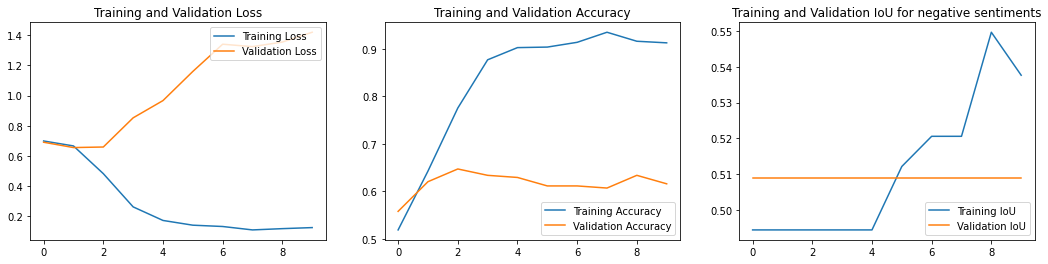

In [120]:
learning_plot(stem_history)

In [121]:
Qtest = tk.texts_to_sequences(X_test)
Xtest = pad_sequences(Qtest,maxlen=maxlen,padding='post' )
print(stem_model.evaluate(Xtest, y_test))

15/15 [==============================] - 0s 5ms/step - loss: 1.3601 - accuracy: 0.6687 - iou_0: 0.5292
[1.3600753545761108, 0.668749988079071, 0.5291666388511658]


## 2. Keras models : Using lemmatized tokents + pretrained fasttext embedding layer + bidirectional LSTM

1. creating training and test dataset

In [68]:
#replacing textual categories by integers
X = [" ".join(w) for w in df_tweet['lemm']]
y = df_tweet['sentiment_num']

#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

print("training size:", len(X_train))
print("testing size:", len(X_test))

training size: 1120
testing size: 480


1. Vectorizng and padding the sequences

In [69]:
#building a dictionary
tk = Tokenizer(num_words=None) #the maximum number of words to keep, based on word frequency
tk.fit_on_texts(X_train)
#1.1 get the size of the dictionary
dico_size = len(tk.word_counts.items())
num_tokens = dico_size + 1
print("size of the dictionary:",dico_size)
print(tk.document_count, 'tweets have been added to the dictionary.')
#words frequency
print("the 10 most frequent words:")
print(sorted(list(tk.word_counts.items()), key=lambda x: -x[1])[:10])

size of the dictionary: 2850
1120 tweets have been added to the dictionary.
the 10 most frequent words:
[('the', 395), ('to', 381), ('my', 238), ('it', 236), ('you', 235), ('and', 220), ('is', 174), ('in', 167), ('for', 161), ('of', 124)]


In [70]:
#2. building a sequneces
seq_X = tk.texts_to_sequences(X_train)
#2.1 calculate maxi length of tweets
max_len = np.max(np.array([len(d) for d in seq_X]))
marg_len=10
maxlen = max_len + marg_len
#3. padding the sequences
Xtrain = pad_sequences(seq_X,maxlen=maxlen,padding='post' )
print("padding size:",maxlen)

padding size: 42


2. loading glove and fasttext embedding vectors

In [71]:
def load_embedding_model(file):

    embedding_model = {}
    with open(file,'r') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            embedding_model[word] = embedding

    return embedding_model

In [72]:
%%time
if 'embedding_index_fasttext' not in locals():
    #load index if not loaded before
    embedding_index_fasttext = load_embedding_model(inputWD+'wiki-news-300d-1M.vec')
    
print('found %s word vectors in loaded fasttext model.' % len(embedding_index_fasttext))

found 999995 word vectors in loaded fasttext model.
CPU times: total: 1min 25s
Wall time: 1min 36s


3. Preparing a corresponding embedding matrix

In [75]:
def embedding_matrix(num_tokens,embedding_dim,embedding_index):
    hits=0
    misses=[]

    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))

    for word, i in tk.word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses.append(word)
    print("Converted %d words (%d misses)" % (hits, len(misses)))
    #print("words not included in pretrained model:",misses)
    
    return embedding_matrix

In [76]:
embedding_dim_fasttext=300
print("from fastText model")
embedding_matrix_fasttext = embedding_matrix(num_tokens,embedding_dim_fasttext,embedding_index_fasttext)

from fastText model
Converted 2769 words (81 misses)


4. Building the model with the embedding layer non trainable

In [167]:
embedding_layer_fasttext = Embedding(
    input_dim=num_tokens,
    output_dim=embedding_dim_fasttext,
    input_length=maxlen,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix_fasttext),
    trainable=False,
)

In [168]:
fasttext_model = Sequential()
#enbedding
fasttext_model.add(embedding_layer_fasttext)
fasttext_model.add(Dropout(0.3))
#LSTM
fasttext_model.add(Bidirectional(LSTM(16,dropout=0.4,recurrent_dropout=0.4)))
# We add a vanilla hidden layer:
fasttext_model.add(Dense(16, activation='relu'))
fasttext_model.add(Dense(8, activation='relu'))
fasttext_model.add(Dropout(0.4))
fasttext_model.add(Dense(units=1, activation='sigmoid',name='predictions'))


#compiling the model
fasttext_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-3, epsilon=1e-08, clipnorm=1.0), 
              loss="binary_crossentropy",
              metrics=metrics)

print(fasttext_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 42, 300)           855300    
                                                                 
 dropout (Dropout)           (None, 42, 300)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 32)               40576     
 l)                                                              
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                        

5. Trainning and evoluating the model

In [169]:
%%time
epochs=12
tf.keras.backend.clear_session()
fast_history = fasttext_model.fit(Xtrain, y_train, batch_size=19,epochs=epochs, validation_split=0.2, verbose=0)

CPU times: total: 3min 7s
Wall time: 1min 37s


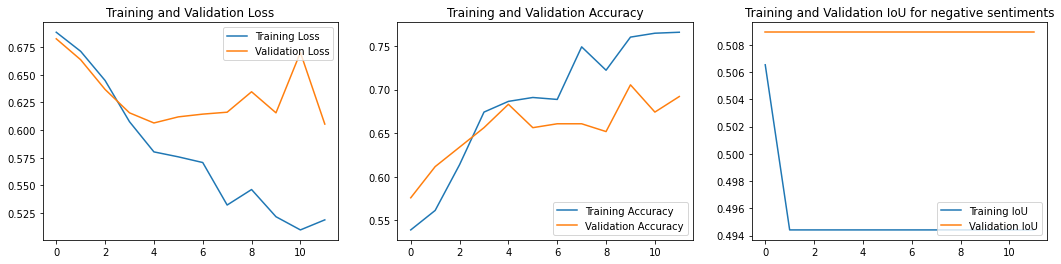

In [170]:
learning_plot(fast_history)

In [171]:
Qtest = tk.texts_to_sequences(X_test)
Ptest = pad_sequences(Qtest,maxlen=maxlen,padding='post' )
print("Test evaluation with fasttext 300d model:")
print(fasttext_model.evaluate(Ptest, y_test))

Test evaluation with fasttext 300d model:
15/15 [==============================] - 2s 77ms/step - loss: 0.5506 - accuracy: 0.7333 - iou_0: 0.5292
[0.5505682229995728, 0.7333333492279053, 0.5291666388511658]


## Using a transfermer architecture model: BERT

1. load the model

In [93]:
if 'bert_model' not in locals():
    bert_model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=2)
    
if 'bert_tokenizer' not in locals():
    bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

2. Split the data

In [94]:
#replacing textual categories by integers
TEXT_COL ='tweet'
LABEL_COL='sentiment_num'
#df_bert = pd.DataFrame(data=pd.concat([pd.Series(X),pd.Series(y)],axis=1, ignore_index=True))
df_bert=df_tweet[[TEXT_COL, LABEL_COL]]
#split
train_df, test_df = train_test_split(df_bert, test_size=0.2, random_state=SEED)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=SEED)

print("training size:", len(train_df))
print("validation size:", len(val_df))
print("testing size:", len(test_df))


training size: 1024
validation size: 256
testing size: 320


3. dataset preperation

In [95]:
#convert data to InputExampls
def convert_data_to_examples(train): 
    data_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[TEXT_COL], 
                                                          text_b = None,
                                                          label = x[LABEL_COL]), axis = 1)
  
    return data_InputExamples

In [96]:
def convert_examples_to_tf_dataset(examples, max_length=64):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = bert_tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            padding='max_length',
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )
    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )
        

In [97]:
train_InputExamples = convert_data_to_examples(train_df)
train_data = convert_examples_to_tf_dataset(list(train_InputExamples))
train_data = train_data.shuffle(100).batch(32)#.repeat(2)

validation_InputExamples = convert_data_to_examples(val_df)
validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples))
validation_data = validation_data.batch(32)

test_InputExamples = convert_data_to_examples(test_df)
test_data = convert_examples_to_tf_dataset(list(test_InputExamples))
test_data = test_data.batch(32)

4. Configuring the BERT model

In [162]:
#compiling the model
bert_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

print(bert_model.summary())

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________
None


5. Train the entire model end-to-end

In [163]:
%%time
epochs=3
bert_history = bert_model.fit(train_data, 
                              epochs=epochs, 
                              use_multiprocessing=True,     
                              workers=-1, 
                              validation_data=validation_data)

Epoch 1/3
32/32 [==============================] - 435s 13s/step - loss: 0.3419 - accuracy: 0.8760 - val_loss: 0.4948 - val_accuracy: 0.7812
Epoch 2/3
32/32 [==============================] - 421s 13s/step - loss: 0.2032 - accuracy: 0.9395 - val_loss: 0.6548 - val_accuracy: 0.7656
Epoch 3/3
32/32 [==============================] - 422s 13s/step - loss: 0.1199 - accuracy: 0.9658 - val_loss: 0.6346 - val_accuracy: 0.7852
CPU times: total: 58min 21s
Wall time: 21min 18s


In [164]:
%%time
print("Test evaluation with BERT model:")
print(bert_model.evaluate(test_data))

Test evaluation with BERT model:
10/10 [==============================] - 39s 4s/step - loss: 0.6816 - accuracy: 0.7781
[0.6815986037254333, 0.778124988079071]
CPU times: total: 1min 34s
Wall time: 38.7 s


In [165]:
#calcul accuracy
y_true = test_df[LABEL_COL].values
#
tf_outputs = bert_model.predict(test_data)
y_pred = tf.nn.softmax(tf_outputs[0], axis=-1)
y_pred = np.argmax(y_pred, axis=1)
acc = np.average(y_true == y_pred)

print("accuracy: {:5.2f}%".format(100 * acc))

accuracy: 77.81%


In [166]:

iou = jaccard_score(y_true, y_pred, pos_label=0, average='binary')
print("iou_0 : {:5.2f}%".format(100 * iou))

iou_0 : 66.82%
